In [1]:
# Import libraries
import sys
sys.path.append('../')
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.feature_selection as skf
import sklearn.utils as sku
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util

from torch import nn
from sklearn.exceptions import ConvergenceWarning
import joblib
from operator import neg
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''<style>.jupyter-matplotlib {background-color: #000;}.widget-label, .jupyter-matplotlib-header{color: #fff;}.jupyter-button {background-color: #333;color: #fff;}</style>''')

In [3]:
cv_names = {'CORNELL ID',
            ' OFF (pre-dbs updrs)',
            ' ON (pre-dbs updrs)',
            ' OFF meds ON stim 6mo'}
            # 'Age',
            # 'Sex',
            # 'Ethnicity',
            # 'Race',
            # 'Disease Duration (year)',
            # 'Physician',
            # ' pre op levadopa equivalent dose (mg)',
            # ' Location',
            # ' Target',
            # ' Test medication status'}

In [4]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/dbs_03292024.csv'
motor_df = util.filter_data(file_dir,cv_names,True)
# Find cases with all required scores
cv_dict = util.filter_cases(motor_df,cv_names)
subs = cv_dict['CORNELL ID']
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
ids = np.asarray(ID_all).astype(int)

# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(cv_dict['CORNELL ID']).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
per_change = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' OFF meds ON stim 6mo'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_updrs = cv_dict[' OFF (pre-dbs updrs)'][s_cases_idx]
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))


Keeping CORNELL ID
Keeping  OFF (pre-dbs updrs)
Keeping  ON (pre-dbs updrs)
Keeping  OFF meds ON stim 6mo
{' OFF (pre-dbs updrs)', 'CORNELL ID', ' OFF meds ON stim 6mo', ' ON (pre-dbs updrs)'}
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '19', '20', '22', '24', '25', '26', '27', '29', '30', '32', '33', '34', '36', '37', '39', '40', '41', '42', '44', '45', '46', '50', '51', '52', '53', '56', '57', '58', '59', '60', '61', '62', '63', '64', '66', '67', '68', '69', '72', '73', '74', '75', '76', '77', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90']
Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix


In [5]:
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
err_var = np.zeros_like(per_change)
alphas = np.logspace(-4,4,100)
Ks = []
Kstg = []
w = []
wg = []
pcases = []
pscores = []
s = []

In [6]:
X = X_all_c.reshape(X_all_c.shape[0],-1)
for cv_name in cv_names:
    if cv_name != ' OFF meds ON stim 6mo':
        print('Appending',cv_name)
        X = np.append(X,cv_dict[cv_name][s_cases_idx].reshape(-1,1),axis=1)
        K = np.append(K,[cv_name],axis=0)
scaler = skp.StandardScaler()
X = scaler.fit_transform(X)

Appending  OFF (pre-dbs updrs)
Appending CORNELL ID
Appending  ON (pre-dbs updrs)


In [7]:
subsc = subs[s_cases_idx]

In [8]:
results_ls = np.zeros_like(per_change)
c = 0
r = 1
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,None,None,None,None,None,None,None,None,None,
                                                False,False,False)
    # 10
    cvn = 10
    cv_scores = np.zeros((cvn,1))
    rs = 1
    for jj in np.arange(2,cvn):
      # Resample to avoid stratification errors
      while np.sum(y_cat) < cvn:
        np.random.seed(rs)
        idyr = np.random.choice(np.asarray(idy).ravel())
        X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
        y_train = np.append(y_train,y_train[idyr])
        y_cat = y_train <= 0.3
        rs = rs+1
        
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=1000,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X0_ss = X0_sst
        est_ls = lasso.fit(X0_ss,y_train)
        cv_scores[jj] = est_ls.score(X0_ss,y_train)
        print('LassoCV score for',jj,'is',cv_scores[jj])
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.argmax(cv_scores)

      # Break any ties
      if np.sum(cv_scores == best_cv) > 1:
        cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
        for jjj in (cv_scores == cv_scores(best_cv)):
          if jjj > 0:
            skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
            skf_gen = skf_g.split(X0_ss0,y_cat) 
            X0_sst = sel.fit_transform(X0_ss0,y_train)
            X0_ss = X0_sst
            lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
            est_ls = lasso.fit(X0_ss,y_train)
            cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
        best_cv = np.argmax(cv_scores_tb)
      
      # Fit whole dataset with optimal cv
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      sel = skf.RFECV(lasso,step=1000,cv=best_cv)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      X0_ss = X0_sst
      X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
    results_ls[c] = est_ls.predict(X_test_ss)
    print('Lasso predicts',str(np.round(results_ls[c],4)),
              'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
  
    c=c+1

      

  


LassoCV score for 2 is [0.89168869]
LassoCV score for 3 is [0.62359618]
LassoCV score for 4 is [0.67467321]
LassoCV score for 5 is [0.40882083]
LassoCV score for 6 is [0.63126862]
LassoCV score for 7 is [0.85962489]
LassoCV score for 8 is [0.153318]
LassoCV score for 9 is [0.96281286]
Lasso predicts 0.5499 for case with 0.71 and selected CV 9
LassoCV score for 2 is [0.15416426]
LassoCV score for 3 is [0.93732479]
LassoCV score for 4 is [0.99985109]
LassoCV score for 5 is [1.]
LassoCV score for 6 is [0.67801144]
LassoCV score for 7 is [0.98435967]
LassoCV score for 8 is [0.99729622]
LassoCV score for 9 is [0.3185115]
Lasso predicts 0.769 for case with 0.5 and selected CV 5
LassoCV score for 2 is [0.06913573]
LassoCV score for 3 is [0.67186121]
LassoCV score for 4 is [0.60095407]
LassoCV score for 5 is [0.15436096]
LassoCV score for 6 is [0.15436096]
LassoCV score for 7 is [0.99998884]
LassoCV score for 8 is [0.15436096]
LassoCV score for 9 is [0.99998419]
Lasso predicts 0.5854 for case 

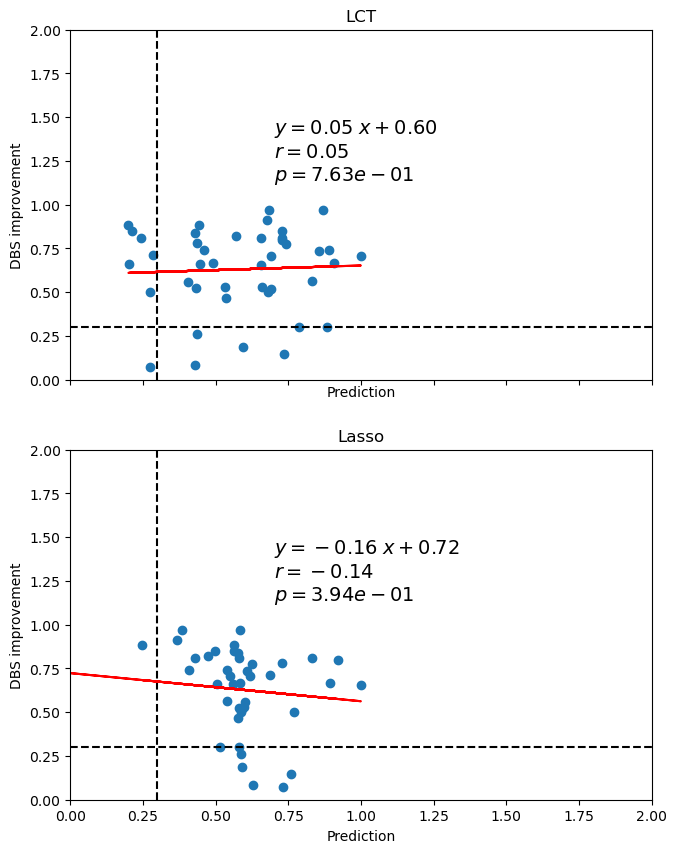

In [10]:
results_ls[results_ls>1] = 1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')